In [41]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [42]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
df = pd.read_csv("logs.csv")

In [44]:
df.to_csv("logs.csv", index=False)

In [45]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [46]:
wr = sum(df['win']) / len(df) * 100
profit = df['profit'].sum()
print(f"ALL TIME Win Rate: {wr:.2f}%")
print(f"ALL TIME Profit: {profit:.2f}$")

ALL TIME Win Rate: 47.45%
ALL TIME Profit: 50.69$


In [47]:
df["date"] = df["timestamp"].dt.date
day_change_indices = df.groupby("date").head(1).index.tolist()[-1]
today_df = df[day_change_indices:]
today_wr = today_df['win'].sum() / len(today_df) * 100
today_profit = today_df['profit'].sum()
print(f"TODAY TIME Win Rate: {today_wr:.2f}%")
print(f"TODAY TIME Profit: {today_profit:.2f}$")

TODAY TIME Win Rate: 55.26%
TODAY TIME Profit: 49.60$


In [48]:
# Expected profit with 50% WR
expected_win = df['opponent_value'].sum() * 0.07
expected_win

np.float64(316.183)

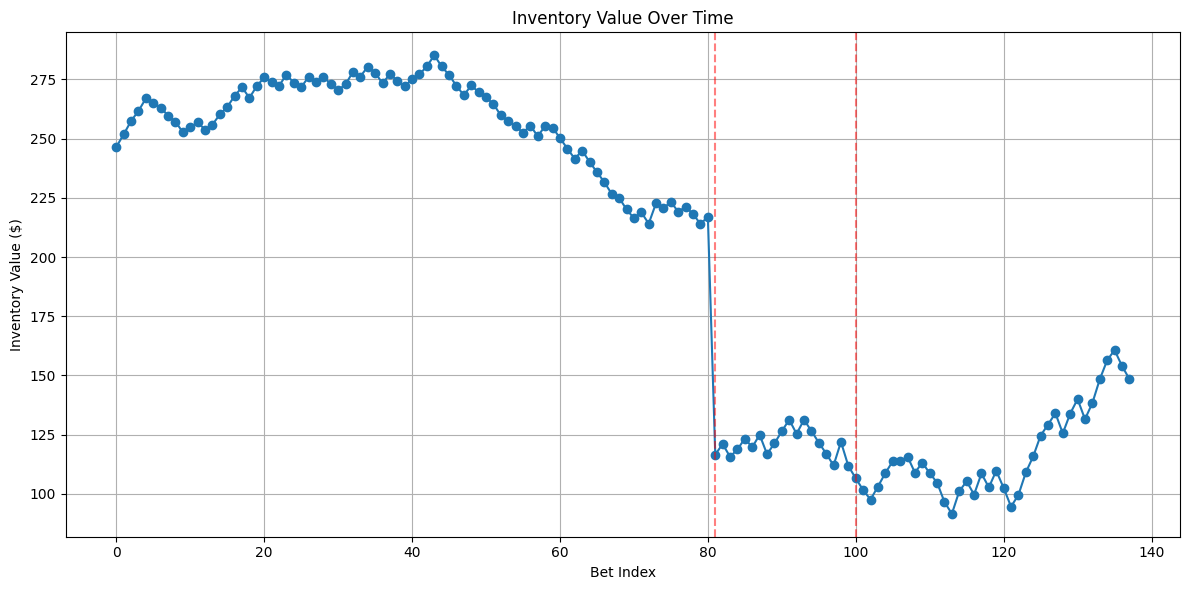

In [49]:
# Filter last N bets
last_n_bets = -len(today_df) - 100
plot_df = df[last_n_bets:].reset_index(drop=True)

# Get the start index of each unique day
plot_df["date"] = plot_df["timestamp"].dt.date
day_change_indices = plot_df.groupby("date").head(1).index.tolist()[1:]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df["inventory_value"], marker='o', linestyle='-')
for idx in day_change_indices:
    plt.axvline(x=idx, color='red', linestyle='--', alpha=0.5)

plt.title("Inventory Value Over Time")
plt.xlabel("Bet Index")
plt.ylabel("Inventory Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

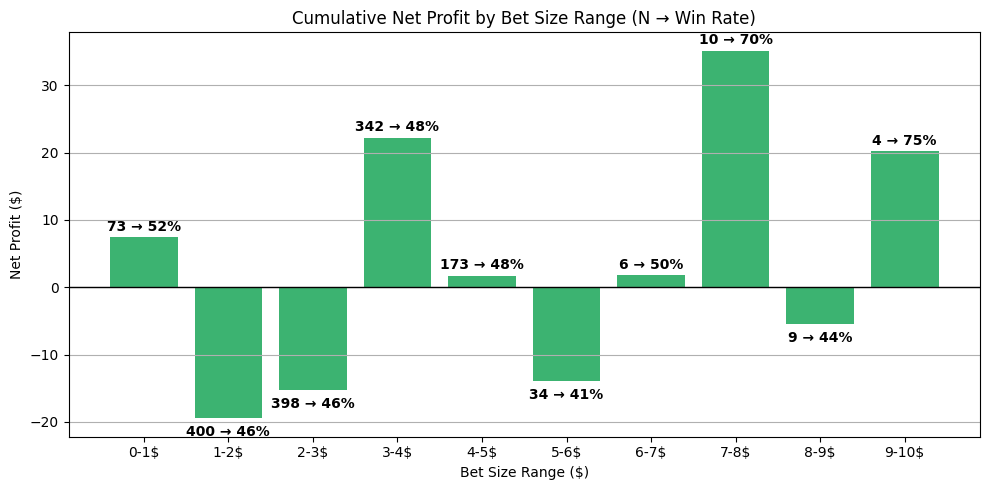

In [50]:
# Recalculate values just to be safe
bins = np.arange(0, 11, 1)
labels = [f"{i}-{i+1}$" for i in bins[:-1]]

df["bet_bin"] = pd.cut(df["your_value"], bins=bins, labels=labels, right=False)

profit_by_bin = df.groupby("bet_bin")["profit"].sum()
win_counts = df[df["win"] == 1].groupby("bet_bin")["win"].count()
total_counts = df.groupby("bet_bin")["win"].count()
win_rate_by_bin = (win_counts / total_counts).fillna(0)

# Fill missing bins to ensure clean bar alignment
profit_by_bin = profit_by_bin.reindex(labels, fill_value=0)
win_rate_by_bin = win_rate_by_bin.reindex(labels, fill_value=0)
total_counts = total_counts.reindex(labels, fill_value=0)
plt.figure(figsize=(10, 5))
bars = plt.bar(profit_by_bin.index, profit_by_bin.values, color="mediumseagreen")

# Add N -> WR% labels above bars
for bar, wr, n in zip(bars, win_rate_by_bin, total_counts):
    height = bar.get_height()
    label_text = f"{n} → {wr:.0%}"
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5 if height >= 0 else height - 1,
        label_text,
        ha='center',
        va='bottom' if height >= 0 else 'top',
        fontsize=10,
        fontweight='bold'
    )

plt.axhline(0, color='black', linewidth=1)
plt.title("Cumulative Net Profit by Bet Size Range (N → Win Rate)")
plt.xlabel("Bet Size Range ($)")
plt.ylabel("Net Profit ($)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


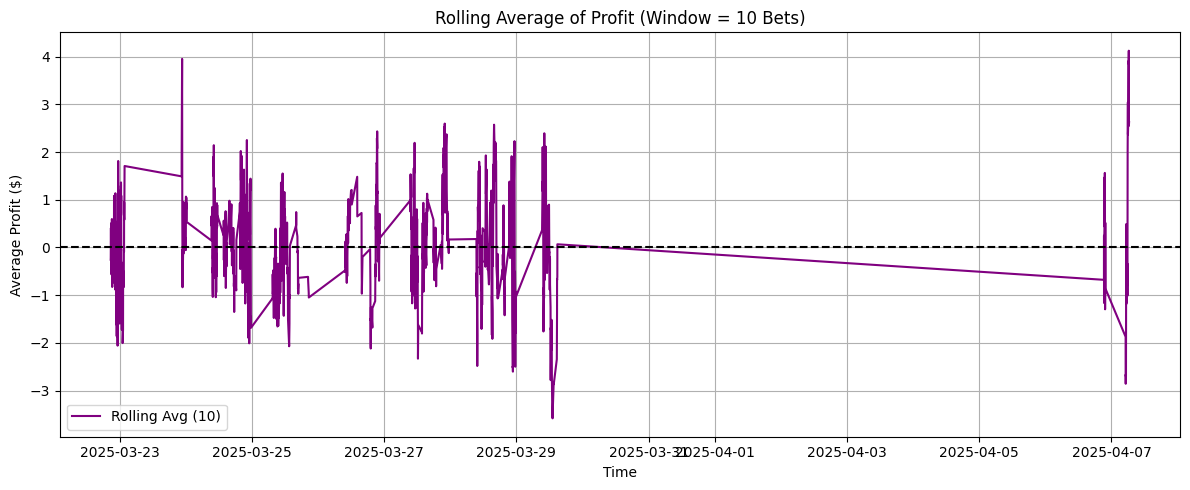

In [51]:
df["rolling_profit"] = df["profit"].rolling(window=10).mean()

plt.figure(figsize=(12, 5))
plt.plot(df["timestamp"], df["rolling_profit"], label="Rolling Avg (10)", color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title("Rolling Average of Profit (Window = 10 Bets)")
plt.xlabel("Time")
plt.ylabel("Average Profit ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Parameters
num_flips = 10000
initial_bankroll = 1000
base_bet = 10
num_simulations = 100

# To store final bankrolls
final_flat = []
final_wr = []
final_anti = []

for _ in range(num_simulations):
    results = np.random.choice([0, 1], size=num_flips)

    # Strategy 1: Flat Betting
    bankroll_flat = initial_bankroll
    for result in results:
        bankroll_flat += base_bet if result == 1 else -base_bet

    # Strategy 2: "WR Fluctuation-Based" Betting
    bankroll_wr = initial_bankroll
    wr_window = 1000
    for i in range(num_flips):
        if i >= wr_window:
            wr = sum(results[i - wr_window:i]) / wr_window
            bet_size = base_bet * 2 if wr < 0.49 else base_bet
        else:
            bet_size = base_bet

        result = results[i]
        bankroll_wr += bet_size if result == 1 else -bet_size

    # Strategy 3: Anti-Martingale (with 3-win cap)
    bankroll_anti = initial_bankroll
    current_bet = base_bet
    win_streak = 0
    for result in results:
        if result == 1:
            win_streak += 1
            bankroll_anti += current_bet
            if win_streak < 6:
                current_bet *= 2
            else:
                current_bet = base_bet
                win_streak = 0
        else:
            bankroll_anti -= current_bet
            current_bet = base_bet
            win_streak = 0

    # Store results
    final_flat.append(bankroll_flat)
    final_wr.append(bankroll_wr)
    final_anti.append(bankroll_anti)

# Create summary DataFrame
summary_df = pd.DataFrame({
    'Flat Betting': final_flat,
    'WR-Based Betting': final_wr,
    'Anti-Martingale': final_anti
})

In [40]:
summary_df.describe()

,Flat Betting,WR-Based Betting,Anti-Martingale
count,100.000000,100.000000,100.000000
mean,1136.200000,1173.000000,2254.900000
std,1028.921942,1279.511823,5595.685476
min,-940.000000,-1800.000000,-10910.000000
25%,420.000000,382.500000,-2175.000000
50%,1220.000000,1220.000000,2565.000000
75%,1785.000000,2100.000000,5987.500000
max,3520.000000,4130.000000,19220.000000
